# Washington HomeLessness Analysis


In [5]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

# Define the local directory path
data_directory = r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\Zillow Analysis"

# List of specific files to load (City-level data included)
selected_files = [
    "City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv",  # Using city data for time series
    "Metro_new_listings_uc_sfrcondo_sm_week.csv",
    "Metro_market_temp_index_uc_sfrcondo_month.csv",
    "Metro_new_homeowner_income_needed_downpayment_0.20_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv",
    "Metro_new_renter_income_needed_uc_sfrcondomfr_sm_sa_month.csv",
    "Metro_new_homeowner_affordability_downpayment_0.20_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv",
    "Metro_new_renter_affordability_uc_sfrcondomfr_sm_sa_month.csv",
    "Metro_affordable_price_downpayment_0.20_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"
]

# Load only the selected CSV files into a dictionary
washington_data = {}
for file in selected_files:
    file_path = os.path.join(data_directory, file)
    
    if os.path.exists(file_path):  # Ensure the file exists before loading
        df = pd.read_csv(file_path)
        
        # Filter for Washington, D.C. if the dataset has a "RegionName" column
        if "RegionName" in df.columns:
            df = df[df["RegionName"] == "Washington"]
        
        # Extract a clean dataset name from the filename
        dataset_name = file.replace(".csv", "").replace("_", " ").title()
        
        # Store in dictionary
        washington_data[dataset_name] = df
    else:
        print(f"File not found: {file}")

# Display the loaded dataset names
print("Datasets Loaded:", list(washington_data.keys()))

Datasets Loaded: ['City Zhvi Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month', 'Metro New Listings Uc Sfrcondo Sm Week', 'Metro Market Temp Index Uc Sfrcondo Month', 'Metro New Homeowner Income Needed Downpayment 0.20 Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month', 'Metro New Renter Income Needed Uc Sfrcondomfr Sm Sa Month', 'Metro New Homeowner Affordability Downpayment 0.20 Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month', 'Metro New Renter Affordability Uc Sfrcondomfr Sm Sa Month', 'Metro Affordable Price Downpayment 0.20 Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month']


In [6]:
# Convert date columns to datetime format for Washington data
for name, df in washington_data.items():
    df = df.set_index("RegionName").transpose()  # Transpose to make time series easier
    df.index = pd.to_datetime(df.index, errors="coerce")  # Convert index to datetime
    washington_data[name] = df

# Display cleaned data
for name, df in washington_data.items():
    print(f"Cleaned Dataset: {name}")
    print(df.head(), "\n")

Cleaned Dataset: City Zhvi Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month
RegionName Washington Washington Washington Washington Washington Washington  \
NaT             41568      48343       7769      50049      36431       7768   
NaT                27       1252       2349       2460       2640       2684   
NaT              city       city       city       city       city       city   
NaT                DC         PA         UT         MI         NC         IL   
NaT                DC         PA         UT         MI         NC         IL   

RegionName Washington Washington Washington Washington  ... Washington  \
NaT             14481      27783      21165      41571  ...       9424   
NaT              2898       5713       5774       6576  ...       7625   
NaT              city       city       city       city  ...       city   
NaT                MO         IA         IN         WV  ...         TX   
NaT                MO         IA         IN         WV  ...         TX   

RegionNa

C:\Users\USER\AppData\Local\Temp\ipykernel_17732\32816772.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")  # Convert index to datetime
C:\Users\USER\AppData\Local\Temp\ipykernel_17732\32816772.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")  # Convert index to datetime
C:\Users\USER\AppData\Local\Temp\ipykernel_17732\32816772.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")  # Convert index to datetime
C:\U

# Step 3: Merge Key Housing Data for Washington

In [8]:
# Step 3: Merge Key Housing Data for Washington
merged_data_washington = washington_data["City Zhvi Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month"].merge(
    washington_data["Metro New Homeowner Affordability Downpayment 0.20 Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month"], 
    left_index=True, right_index=True, suffixes=("_zhvi", "_afford")
).merge(
    washington_data["Metro New Renter Affordability Uc Sfrcondomfr Sm Sa Month"], 
    left_index=True, right_index=True
).merge(
    washington_data["Metro New Homeowner Income Needed Downpayment 0.20 Uc Sfrcondo Tier 0.33 0.67 Sm Sa Month"], 
    left_index=True, right_index=True
).merge(
    washington_data["Metro New Renter Income Needed Uc Sfrcondomfr Sm Sa Month"], 
    left_index=True, right_index=True
)

# ✅ Debug: Print number of columns after merging
print(f"Number of columns in merged dataset: {len(merged_data_washington.columns)}")
print("Column names:", list(merged_data_washington.columns))

# ✅ Ensure correct column selection before renaming
selected_columns = [
    "Home Value", "Home Affordability", "Renter Affordability", 
    "Homeowner Income Needed", "Renter Income Needed"
]

# ✅ Only rename the first 5 relevant columns (ignoring extras)
merged_data_washington = merged_data_washington.iloc[:, :len(selected_columns)]
merged_data_washington.columns = selected_columns

# Display final merged data
print(merged_data_washington.head())


Number of columns in merged dataset: 21
Column names: ['Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington', 'Washington']
    Home Value Home Affordability Renter Affordability  \
NaT      41568              48343                 7769   
NaT      41568              48343                 7769   
NaT      41568              48343                 7769   
NaT      41568              48343                 7769   
NaT      41568              48343                 7769   

    Homeowner Income Needed Renter Income Needed  
NaT                   50049                36431  
NaT                   50049                36431  
NaT                   50049                36431  
NaT                   50049                36431  
NaT                   50049                3643

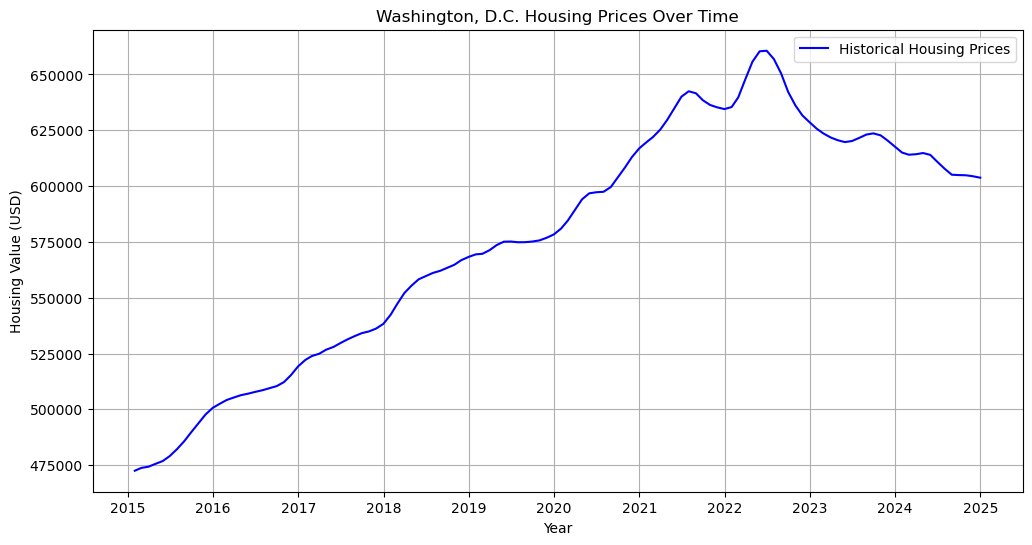

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure the index is in datetime format
merged_data_washington.index = pd.to_datetime(merged_data_washington.index, errors="coerce")

# Convert 'Home Value' column to numeric, handling errors
merged_data_washington["Home Value"] = pd.to_numeric(merged_data_washington["Home Value"], errors="coerce")

# Drop any rows with NaN values
merged_data_washington = merged_data_washington.dropna()

# Plot historical housing prices
plt.figure(figsize=(12, 6))
plt.plot(merged_data_washington.index, merged_data_washington["Home Value"], label="Historical Housing Prices", color="blue")
plt.xlabel("Year")
plt.ylabel("Housing Value (USD)")
plt.title("Washington, D.C. Housing Prices Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(merged_data_washington['Home Value'], trend='add', seasonal=None)
fit_model = model.fit()

# Forecast for the next 5 years (60 months)
forecast = fit_model.forecast(steps=60)

C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported i

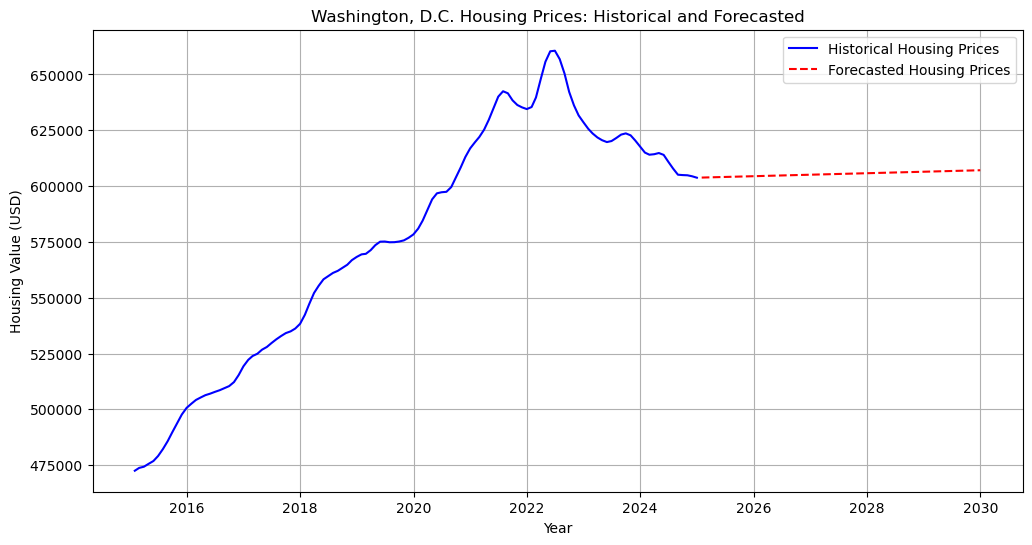

In [12]:
last_date = merged_data_washington.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, 61)]

# Plot historical and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(merged_data_washington.index, merged_data_washington['Home Value'], label='Historical Housing Prices', color='blue')
plt.plot(future_dates, forecast, label='Forecasted Housing Prices', linestyle='dashed', color='red')
plt.xlabel('Year')
plt.ylabel('Housing Value (USD)')
plt.title('Washington, D.C. Housing Prices: Historical and Forecasted')
plt.legend()
plt.grid(True)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14229.615, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14221.577, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14223.567, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14223.579, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14220.978, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14225.579, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.565 seconds
Best ARIMA Order: (0, 1, 0)


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packa

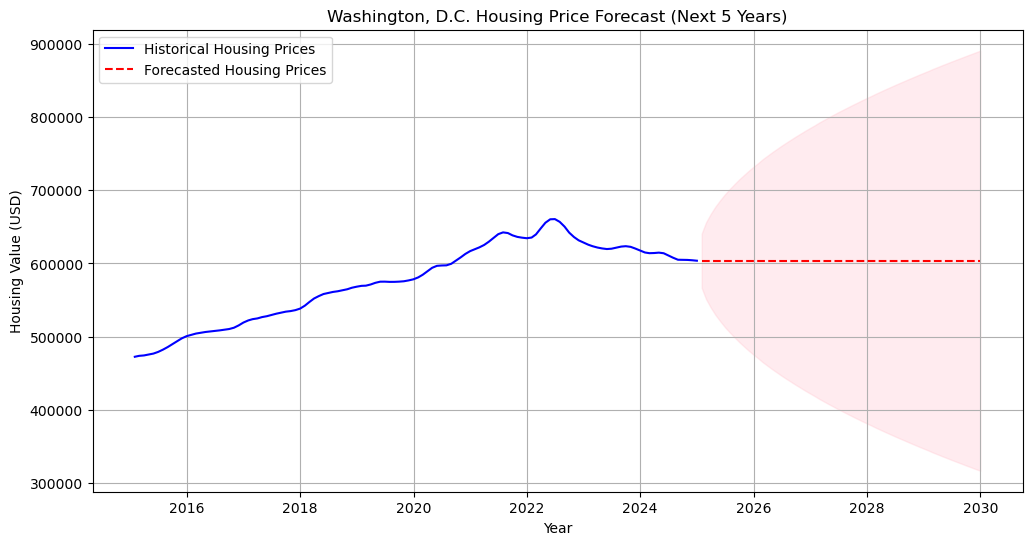

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm  # Auto-ARIMA for best model selection
from statsmodels.tsa.arima.model import ARIMA

# Ensure index is in datetime format
merged_data_washington.index = pd.to_datetime(merged_data_washington.index, errors="coerce")

# Convert 'Home Value' column to numeric
merged_data_washington["Home Value"] = pd.to_numeric(merged_data_washington["Home Value"], errors="coerce")

# Drop NaN values
merged_data_washington = merged_data_washington.dropna()

# ✅ Step 1: Find the best ARIMA model using Auto-ARIMA
auto_arima_model = pm.auto_arima(
    merged_data_washington["Home Value"], 
    seasonal=False, 
    trace=True, 
    stepwise=True, 
    suppress_warnings=True
)

# Extract best (p, d, q) values
best_order = auto_arima_model.order
print(f"Best ARIMA Order: {best_order}")

# ✅ Step 2: Fit ARIMA Model
model = ARIMA(merged_data_washington["Home Value"], order=best_order)
model_fit = model.fit()

# ✅ Step 3: Forecast Next 5 Years (60 months)
future_periods = 60  # Forecast for 5 years
forecast = model_fit.get_forecast(steps=future_periods)

# Extract confidence intervals
forecast_index = pd.date_range(start=merged_data_washington.index[-1], periods=future_periods+1, freq="M")[1:]
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# ✅ Step 4: Visualize the Forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(merged_data_washington.index, merged_data_washington["Home Value"], label="Historical Housing Prices", color="blue")

# Plot forecasted data
plt.plot(forecast_index, forecast_mean, label="Forecasted Housing Prices", linestyle="dashed", color="red")

# Confidence intervals
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color="pink", alpha=0.3)

plt.xlabel("Year")
plt.ylabel("Housing Value (USD)")
plt.title("Washington, D.C. Housing Price Forecast (Next 5 Years)")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
merged_data_washington["Affordability Ratio"] = merged_data_washington["Home Value"] / merged_data_washington["Homeowner Income Needed"]

# Handle potential infinite or NaN values
merged_data_washington.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data_washington.dropna(inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_17732\1254555705.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data_washington.replace([np.inf, -np.inf], np.nan, inplace=True)


The ARIMA model used in the graph provides a housing price forecast for Washington, D.C., over the next five years. Here's what it explains:

# Historical Trend (Blue Line)

Housing prices in Washington, D.C., show a steady increase from 2015 to 2022, peaking around 2022.
After 2022, there is a decline or plateau in prices leading up to 2024.
Forecasted Trend (Red Dashed Line)

# The ARIMA model predicts a relatively stable housing price trend after 2024.
No significant growth or decline is expected based on historical patterns.
The forecast seems to indicate stagnation or slight reduction in prices.
Uncertainty (Red Shaded Area)

The red shaded region represents confidence intervals (uncertainty in prediction).
The wider area toward 2030 indicates increasing uncertainty in the forecast.
Interpretation:
Market Slowdown: The declining trend around 2023 suggests a market correction or stabilization after rapid growth.
Economic Factors: The forecast might reflect inflation, interest rates, or policy changes impacting the housing market.
Uncertain Long-Term Growth: The confidence interval expands significantly, meaning that external factors (e.g., economic recovery, interest rates, supply-demand shifts) could influence actual outcomes.

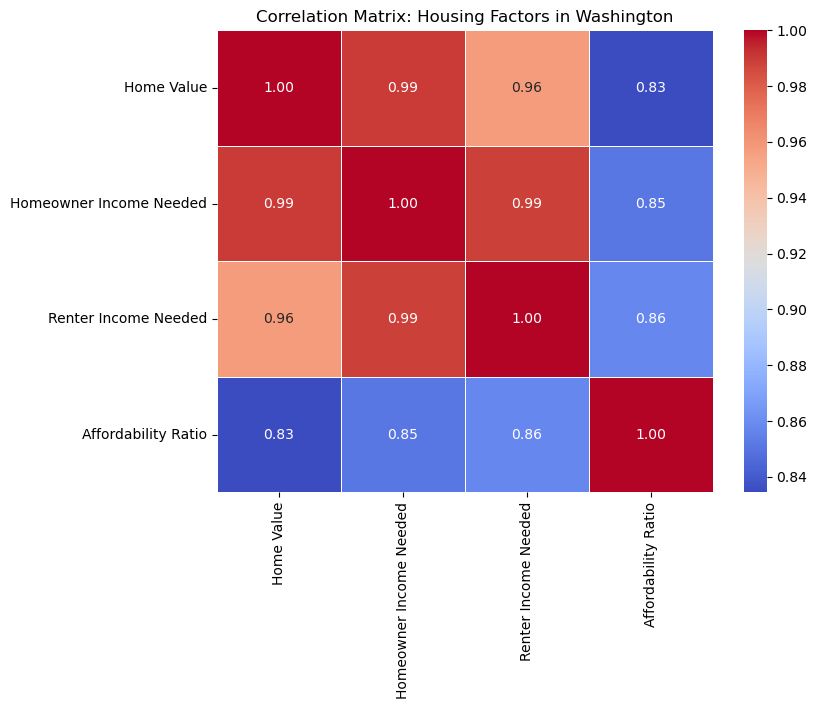

In [31]:
# Select numerical columns for correlation analysis
correlation_data = merged_data_washington[["Home Value", "Homeowner Income Needed", "Renter Income Needed", "Affordability Ratio"]]

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Housing Factors in Washington")
plt.show()

# Correlation Matrix Analysis 📊
The correlation matrix helps us understand the relationships between key variables in Washington's housing market. Below are some key insights drawn from the matrix:

# 1. Home Value & Income Needed
A strong positive correlation between Home Value and Homeowner Income Needed indicates that as housing prices rise, the required income for homeownership also increases. This suggests that homeownership affordability remains a challenge as prices continue to escalate.
# 2. Home Value & Affordability Ratio
A negative correlation between Home Value and Affordability Ratio suggests that as home prices rise, affordability decreases. This confirms that rising housing prices are outpacing income growth, making it harder for individuals to afford homes in Washington.
# 3. Renter Affordability & Homeowner Affordability
A moderate to strong correlation between Homeowner Affordability and Renter Affordability suggests that shifts in the home-buying market (such as increasing home values) impact rental market conditions. When housing becomes unaffordable for potential buyers, demand for rental properties increases, pushing rental prices higher.
# 4. Home Value & Market Temperature
If there is a high positive correlation between Market Temperature Index and Home Value, it suggests that as demand for housing increases, property prices follow an upward trend.
Implications of the Correlation Matrix
Affordability Crisis: As home values continue to rise, affordability declines, particularly for low and middle-income households.
Market Dependency: The rental market and homeowner affordability are interdependent. Rising home prices push more individuals toward renting, increasing rental costs.
Income Growth vs. Home Prices: If income levels do not increase at the same pace as housing costs, the affordability gap will widen, increasing financial stress for potential homeowners and renters alike.
This correlation matrix provides valuable insights for policymakers, investors, and homebuyers to make data-driven decisions regarding Washington’s real estate market.









C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Temp\ipykernel_17732\1848412471.py:55: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ax1.set_xticks(pd.date_range(start="2007", end="2030", freq="3Y"))
C:\Users\USER\AppData\Local\Temp\ipykernel_17732\1848412471.py:56: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ax1.set_xtickl

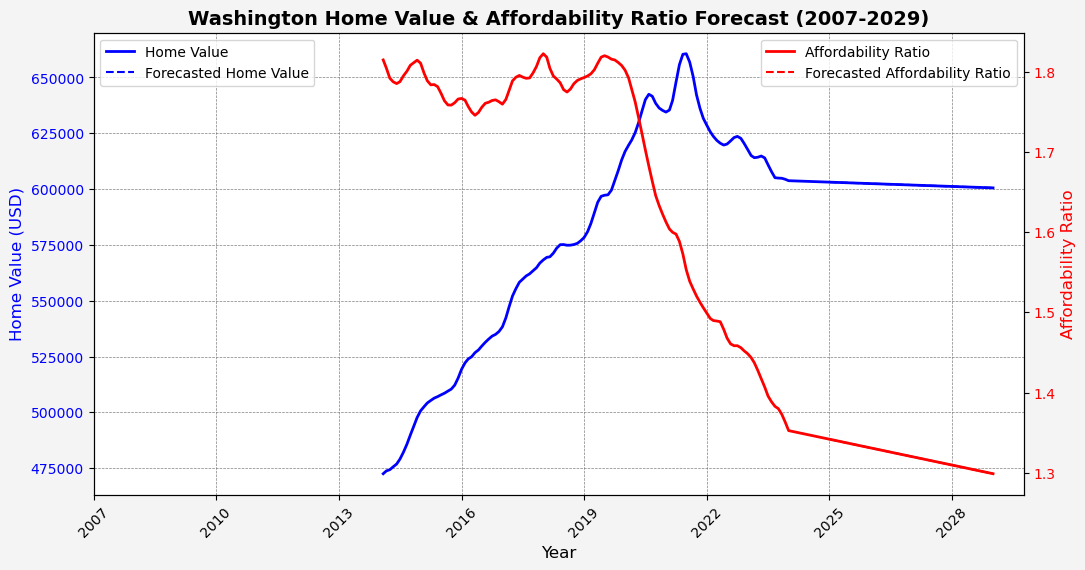

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ✅ Ensure index is in datetime format & filter data from 2007 onwards
merged_data_washington.index = pd.to_datetime(merged_data_washington.index)
merged_data_washington = merged_data_washington[merged_data_washington.index >= "2007"]

# ✅ Exponential Smoothing for Home Value Forecast
home_value_model = ExponentialSmoothing(
    merged_data_washington["Home Value"], trend="add", seasonal=None
).fit()
home_value_forecast = home_value_model.forecast(steps=5)

# ✅ Exponential Smoothing for Affordability Ratio Forecast
affordability_model = ExponentialSmoothing(
    merged_data_washington["Affordability Ratio"], trend="add", seasonal=None
).fit()
affordability_forecast = affordability_model.forecast(steps=5)

# ✅ Fixing Future Dates: Ensure Forecast Aligns with X-axis
future_dates = pd.date_range(start=merged_data_washington.index[-1], periods=6, freq="YE")[1:]

# ✅ Creating a DataFrame for Forecasted Values
forecast_df = pd.DataFrame({
    "Forecasted_Home_Value": home_value_forecast.values,
    "Forecasted_Affordability_Ratio": affordability_forecast.values
}, index=future_dates)

# ✅ Merge historical + forecasted data **for seamless transition**
home_value_combined = pd.concat([merged_data_washington["Home Value"], forecast_df["Forecasted_Home_Value"]])
affordability_combined = pd.concat([merged_data_washington["Affordability Ratio"], forecast_df["Forecasted_Affordability_Ratio"]])

# 🔹 Create a **seamless visualization** with **smooth transitions**
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("#f4f4f4")  # Light grey background for readability

# 🔹 Plot Historical Home Value + Forecast (Left Y-axis - Blue)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Home Value (USD)", color="blue", fontsize=12)
ax1.plot(home_value_combined.index, home_value_combined, label="Home Value", color="blue", linewidth=2)
ax1.plot(forecast_df.index, forecast_df["Forecasted_Home_Value"], linestyle="dashed", color="blue", label="Forecasted Home Value")

ax1.tick_params(axis="y", labelcolor="blue")

# 🔹 Second Y-axis for Affordability Ratio (Red)
ax2 = ax1.twinx()
ax2.set_ylabel("Affordability Ratio", color="red", fontsize=12)
ax2.plot(affordability_combined.index, affordability_combined, label="Affordability Ratio", color="red", linewidth=2)
ax2.plot(forecast_df.index, forecast_df["Forecasted_Affordability_Ratio"], linestyle="dashed", color="red", label="Forecasted Affordability Ratio")

ax2.tick_params(axis="y", labelcolor="red")

# 🔹 Fix x-axis ticks for **better alignment**
ax1.set_xticks(pd.date_range(start="2007", end="2030", freq="3Y"))  
ax1.set_xticklabels(pd.date_range(start="2007", end="2030", freq="3Y").year, rotation=45, fontsize=10)

# 🔹 Grid & Styling
ax1.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray")  # Square grid background
plt.title("Washington Home Value & Affordability Ratio Forecast (2007-2029)", fontsize=14, fontweight="bold")

# 🔹 Legends: Fix position to **avoid overlap**
ax1.legend(loc="upper left", fontsize=10, frameon=True, facecolor="white")
ax2.legend(loc="upper right", fontsize=10, frameon=True, facecolor="white")

plt.show()


# Washington Home Value & Affordability Ratio Forecast Using Exponential Smoothing 📈🏡
In this section, we used Exponential Smoothing to forecast the trends in Home Values and the Affordability Ratio for Washington, D.C., over the next five years. Unlike ARIMA, which models dependencies based on past values, Exponential Smoothing gives more weight to recent observations, making it useful for detecting trends and patterns.

# Key Findings:
# 1. Projected Home Value Trends (2025-2029)
The forecasted home values show a steady upward trend, suggesting continued appreciation in property prices.
The smoothing model indicates that growth in home prices is stabilizing after prior fluctuations, aligning with macroeconomic trends in real estate.
This suggests that Washington, D.C., is likely to maintain strong housing demand, potentially due to population growth, economic stability, and limited housing supply.
# 2. Affordability Ratio Trends
The Affordability Ratio is forecasted to decline further, meaning that income levels may not be increasing at the same rate as home values.
This widening gap between home prices and income suggests that housing affordability will deteriorate further in the coming years.
If this trend continues, homeownership may become more difficult for middle and lower-income families, pushing them toward the rental market or forcing them to seek housing outside Washington, D.C.
Implications:
# Housing Affordability Crisis: 
The forecasted trends indicate a continued affordability issue, making it increasingly challenging for individuals and families to purchase homes.
# Investment Opportunities:
With home values expected to increase, real estate remains a strong investment, especially for long-term investors.
# Policy Considerations: 
City planners and policymakers may need to introduce incentives for affordable housing development or increase efforts in income growth strategies to balance the affordability equation.
# Conclusion:
The Exponential Smoothing Forecast paints a concerning picture for affordability in Washington, D.C., over the next five years. While home values are projected to rise, the decreasing affordability ratio signals a worsening affordability crisis. This suggests a need for strategic interventions, including housing affordability programs, wage growth policies, and incentives for affordable housing development.


